# Plos Pipeline

## Algorithm
#### Description
The PLOS Pipeline algorithm intends to convert a multiplex flourescence microscopy or immunoflourescence array topography volume to a probability volume representing the probability that any single voxel is a synapse. For our purposes, we will be utilizing the first 3 steps of this pipeline, namely:
1. Computation of Foreground Probability
2. Probability of 2D Puncta
3. Probability of 3D Puncta

#### Inputs
A 3-D image volume obtained through In-vivo two photon SEP-GluA1 imaging.

#### Outputs
A probability volume representing the probability that any one voxel in the volume is a synapse

#### Function

In [5]:
###THIS IS PSEUDOCODE, DO NOT RUN###

###STEP 1: COMPUTATION OF FOREGROUND PROBABILITY###
cdfMapVolume = []
for image in volume:
    
    #Get a distribution of intensities of the slice
    dist = generateDistribution(image)
    
    #Get the cdf for every voxel in the image slice
    cdfMap = zeros_like(dist)
    for y in image.height:
        for x in image.width:
            cdfMap[y][x] = dist.cdf(image[y][x])
    cdfMapVolume.apend(cdfMap)
    
####Step 2: Probability of 2D Puncta
filteredVolume = zeros_like(cdfMapVolume)
for z in cdfMapVolume.depth:
    for y in cdfMapVolume.height:
        for x in cdfMapVolume.width:
            #NOTE: boxFilter apples a box filter(duh...) of size at the given zyx
            #this boxFilter is equivalent to the product of all elements that are <=size
            #away from the zyx center, and are on the same z slice.
            filteredVolume[z][y][x] = boxFilter(cdfMapVolume, z, y, x, size)
            
####Step 3: Probability of 3D Puncta
finalVolume = zeros_like(filteredVolume)
for z in filteredVolume.depth:
    for y in filteredVolume.height:
        for x in filteredVolume.width:
            #getSquaredError calculates the sum of the squared error between the provided zyx voxel
            #and the voxel at the same yx points within size distance of z (i.e. up and down z axis)
            finalVolume[z][y][x] = filteredVolume[z][y][x] * exp(-1 * getSquaredError(filteredVolume, z, y, x, size))

NameError: name 'volume' is not defined

## Simulation
### Unit Testing
Unit tests were developed to validate the output of all major functions withing the PLOS Pipeline. These tests can be found here:

https://github.com/NeuroDataDesign/pan-synapse/tree/master/code/tests

Relevant unit tests for the PLOS pipeline include:
- generate2PunctaMapTest.py
- prodConvTest.py
- generateForegroundProbMapTest.py
- interVoxSquaredErrorTest.py

### Pipeline Testing
Data will be sampled from two synthetic sets, one with two 3x3x3 'synapse' clusters of intensity 100 within a 20x20x20 volume, and one of uniform data with value 100 within a 20x20x20 volume.

#### Success
- We expect the pipeline to identify a high probability of synapse for the two clusters in the synthetic synapse data

#### Faulure
- We expect the pipeline to identify the entire volume as a high probability of synapse for the uniform data since there is no variance in the data.

## Analysis
#### Qualitative Visualizations
We will plot a 3D scatter plot of perdicted synapse probabilities with more intense 

#### Quantitative Score
For the synapse cluster synthetic data set, we will score the pipeline based on if it finds both, one, or 0 of the 'synapse' clusters. (This evaluation will be made after an OTSU binarization of the data, where a found synapse voxel will have a value of 1 and a non-synapse voxel will have a value of 0)

#### P Value and Test Statistic
We will create a null distribution by running a permutation test (i.e. randomly assigning cluster labels to points and recording the distribution of performance as defined by the misclassification rate), and the p-value will be reported as 1 minus the fraction of times the algorithm performs better than points in the null distribution

## Write Code
All code for this PLOS Pipeline can be found in our plosLib.py file, located here:

https://github.com/NeuroDataDesign/pan-synapse/blob/master/code/functions/plosLib.py

### 1. Generate Data

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pickle
import sys
sys.path.insert(0,'../code/functions/')

twoClusterDat = pickle.load(open('../code/tests/synthDat/twoPerfectClusters.synth'))
all100Dat = pickle.load(open('../code/tests/synthDat/all100.synth'))

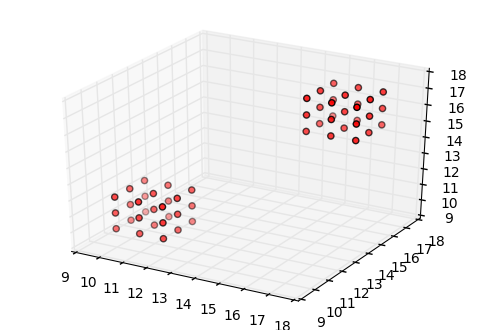

In [7]:
#The two cluster data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
z, y, x = twoClusterDat.nonzero()
ax.scatter(x, y, z, zdir='z', c='r')
plt.show()

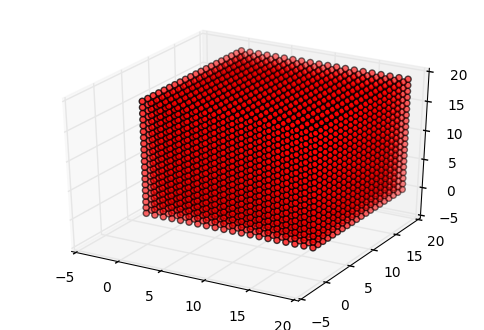

In [9]:
#The uniform data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
z, y, x = all100Dat.nonzero()
ax.scatter(x, y, z, zdir='z', c='r')
plt.show()

In [16]:
#Get the implemented library code
import plosLib as pLib
import connectLib as cLib

In [20]:
twoClusterResults = pLib.pipeline(twoClusterDat)
a = cLib.otsuVox(twoClusterResults)

ValueError: range parameter must be finite.